<a href="https://colab.research.google.com/github/fbeilstein/machine_learning/blob/master/lecture_11_decision_trees_and_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decision trees and random forests



Random forests are an example of an ensemble method, a method that relies on aggregating the results of an ensemble of simpler estimators. The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts.

#Logical methods of classification

* $X$ -- objects
* $Y$ -- classes

We can state different rules $\phi$ (predicates) and some of them are good with respect to class $y$ in sense of
* maximizing $|\{x \mid \phi(x_i) = T \wedge y_i = y\}|$ (true positives)
* minimizing $|\{x \mid \phi(x_i) = T \wedge y_i \neq y\}|$ (false positives)
* simple, interpretable

**Note:** 
* features can be not only interval, but nominal, etc.
* creating such functions is *Knowledge extraction*

* How to invent features?
   - Art, not science
* What kind of equations do we need?
   - Simple, depending on minimal number of features
* What defines informativity (інформативність)?
   - Large number of true positives + small number of false positives.
* Hot to find regularities (закономірності)?
   - feature selection
* How to make an algorithm from features?
  - Classificators composition

**Example**
* **If** the patient is old (age > 60)
* **And** he had a stroke
* **Then** operation is dangerous (survival rate < 50%)

**Where do we get probabilities?**
* Split the dataset and estimate

**Rule induction procedure:**
* Choose the family of acceptable rules;
* Rule generation;
* Rule selection;
* Create classifier from rules as features(example: weighted voting)

In [1]:
#@title Decision Tree by Hands

%%html

<html>

<head>
<style>

.tree {
  font-family: sans-serif;
  font-size: 15px;
}

.tree ul {
  position: relative;
    padding: 1em 0; 
  white-space: nowrap;
  margin: 0 auto;
  text-align: center;
  &::after {
    content: '';
    display: table;
    clear: both;
  }
}
.tree li {
  display: inline-block; 
  vertical-align: top;
  text-align: center;
  list-style-type: none;
  position: relative;
  padding: 1em .5em 0 .5em;
}

.tree li:before {
    content: '';
    position: absolute; 
    top: 0; 
    right: 50%;
    border-top: 2px solid #ccc;
    width: 50%; 
    height: 1em;
}
.tree li:after {
    content: '';
    position: absolute; 
    top: 0; 
    right: 50%;
    border-top: 2px solid #ccc;
    width: 50%; 
    height: 1em;
}
.tree li:after {
    right: auto; 
    left: 50%;
    border-left: 2px solid #ccc;
}
.tree li:only-child::after {
    display: none;
}
.tree li:only-child::before {
    display: none;
}
.tree li:only-child {
    padding-top: 0;
}
.tree li:first-child::before {
    border: 0 none;
}
.tree li:last-child::after {
    border: 0 none;
}
.tree li:last-child::before {
    border-right: 2px solid #ccc;
    border-radius: 0 5px 0 0;
}
.tree li:first-child::after {
    border-radius: 5px 0 0 0;
}

.tree ul ul::before{
    content: '';
    position: absolute; 
    top: 0; 
    left: 50%;
    border-left: 2px solid #ccc;
    width: 0; 
    height: 1em;
}

.tree li a {
    border: 2px solid #ccc;
    padding: .5em .75em;
    text-decoration: none;
    text-align: left;
    display: inline-block;
    border-radius: 5px;
    color: #333;
    position: relative;
    top: 2px;
}

.tree li a:hover,
.tree li a:hover+ul li a {
  background: #00554f;
  color: #fff;
  border: 2px solid #e9453f;
}

.tree li a:hover + ul li::after, 
.tree li a:hover + ul li::before, 
.tree li a:hover + ul::before, 
.tree li a:hover + ul ul::before{
    border-color:  #e9453f;
}
</style>

  <script src="https://cdn.plot.ly/plotly-latest.min.js"></script> 

  <script type="application/javascript">


    var x_min = 0.0;
    var y_min = 0.0;
    var x_max = 1.0;
    var y_max = 1.0;
    var xs = [];
    var ys = [];
    for (var x = x_min; x <= x_max; x += 0.01)
      xs.push(x);
    for (var y = y_min; y <= y_max; y += 0.01)
      ys.push(y);
    var colors = ['blue', 'red'];



    function loss_function_2d() {
      var blue_x = [];
      var blue_y = [];
      var red_x = [];
      var red_y = [];
      for (var i = 0; i < points.length; ++i) {
        if (points[i][2]) {
            blue_x.push(points[i][0]);
            blue_y.push(points[i][1]);
        } else {
            red_x.push(points[i][0]);
            red_y.push(points[i][1]);
        }
      }

      data = [];

      // datapoints
      data.push({
            x: red_x, y: red_y,
            showscale: false, opacity: 1.0, type: 'scatter', mode: 'markers',
            name: 'red class datapoints',
            marker: {size: 12, color: 'red'},
      });
      data.push({
            x: blue_x, y: blue_y,
            showscale: false, opacity: 1.0, type: 'scatter', mode: 'markers',
            name: 'red class datapoints',
            marker: {size: 12, color: 'blue'},
      });

      lines = [];
      if (root_node)
        lines = root_node.get_split_lines(lines);
      //console.log(lines);
      var lines_x = [];
      var lines_y = [];
      var active  = [[-10,-10],[-10,10]];
      for (var i = 0; i < lines.length; ++i) {
        if (lines[i][2]) {
            active = lines[i];
            continue;
        }
        lines_x.push(lines[i][0][0]);
        lines_x.push(lines[i][1][0]);
        lines_x.push(null);
        lines_y.push(lines[i][0][1]);
        lines_y.push(lines[i][1][1]);
        lines_y.push(null);        
      }
    data.push({
        x: lines_x,
        y: lines_y,
        showscale: false, opacity: 1.0, type: 'scatter', mode: 'lines',
        showlegend: false,
        line: {width: 3, color: 'green'},
    });
    data.push({
        x: [active[0][0], active[1][0]],
        y: [active[0][1], active[1][1]],
        showscale: false, opacity: 1.0, type: 'scatter', mode: 'lines',
        showlegend: false,
        line: {width: 3, color: 'yellow'},
    });

    var zs = [];
    for (var j = 0; root_node && j < ys.length; ++j) {
        var temp = [];
        for (var i = 0; i < xs.length; ++i)
            temp.push(root_node.get_red_concentration([xs[i], ys[j]]))
        zs.push(temp);
    }
    //console.log(zs);
    if(zs.length) {
        zs[0][0] = 0.0;
        zs[0][1] = 1.0;
    }
    data.push({
        x: xs,
        y: ys,
        z: zs,
        showscale: false, 
        opacity: 0.2, 
        colorscale: 'RdBu', //[[0, 'blue'], [1, 'red']],
        type: 'heatmap'
    });

      var cell_for_plot = document.getElementById("for_right_plot");
      var layout = {
          title: 'Decision Tree',
          xaxis: {'range': [x_min, x_max], 'domain': [0.0, 1.0], 'fixedrange': true},
          yaxis: {'range': [y_min, y_max], 'domain': [0.0, 1.0], 'fixedrange': true},
          width: 600,
          height: 600,
          autosize: false,
          showlegend: false,
          margin: {l: 0, r: 0, b: 0, t: 0 }
        };
      Plotly.newPlot(cell_for_plot, data, layout);
    }


    class TreeNode {
        constructor(parent, side, container, box) {
            this.parent    = parent;
            this.side      = side;
            this.left      = null;
            this.right     = null;
            this.container = container;
            this.name      = this.parent ? this.parent.name + side : side;
            this.active    = false;
            this.box       = box;
            this.split     = [null, null];
            this.prob_red  = 0.5;
        }
        create_child(tree_node, element, mode) {
            const box = document.createElement("a");
            element.appendChild(box);
            var str = '';
            if (mode == 'L')
                str += '<div style="position:absolute; top:-20px;" id="' + tree_node.name + '_prob"></div>';
            else
                str += '<div style="position:absolute; top:-20px; left:120px" id="' + tree_node.name + '_prob"></div>';
            str    += '<b><label id="' + tree_node.name + '_cond"></label></b>  ';
            str    += '<b style="color:red">Red:</b> <label id="' + tree_node.name + '_red"></label>';
            str    += '<b style="color:blue">Blue:</b> <label id="' + tree_node.name + '_blue"></label><br>';
            str    += '<b>Gini:</b><label id="' + tree_node.name + '_gini"></label>';
            str    += '<b>Entropy:</b><label id="' + tree_node.name + '_ent"></label><br>';
            str    += '<input type="radio" id="' + tree_node.name + '_leaf" name="' + tree_node.name + '" checked="checked">';
            str    += '<label for="' + tree_node.name + '_leaf">Make Leaf Node</label><br>'; 
            str    += '<input type="radio" id="' + tree_node.name + '_x" name="' + tree_node.name + '">';
            str    += '<label for="' + tree_node.name + '_x">Split feature X</label><br>';
            str    += '<input type="radio" id="' + tree_node.name + '_y" name="' + tree_node.name + '">';
            str    += '<label for="' + tree_node.name + '_y">Split feature Y</label>';
            box.innerHTML = str;
            document.getElementById(tree_node.name + '_leaf').onclick = function(){ tree_node.delete_children(); loss_function_2d(); }
            document.getElementById(tree_node.name + '_x').onclick    = function(){ tree_node.activate_x(); loss_function_2d(); }
            document.getElementById(tree_node.name + '_y').onclick    = function(){ tree_node.activate_y(); loss_function_2d(); }

        }
        update_cildren() {
            if (this.split[0]) {
                this.left.box  = [[this.box[0][0], this.split[0]], this.box[1]];
                this.right.box = [[this.split[0], this.box[0][1]], this.box[1]];
            } else {
                this.left.box  = [this.box[0], [this.box[1][0], this.split[1]]];
                this.right.box = [this.box[0], [this.split[1], this.box[1][1]]];   
            }
            var left_red   = 0;
            var left_blue  = 0;
            var right_red  = 0;
            var right_blue = 0;
            for (var i = 0; i < points.length; ++i) {
                if (this.left.box[0][0] < points[i][0] && points[i][0] < this.left.box[0][1] && this.left.box[1][0] < points[i][1] && points[i][1] < this.left.box[1][1])
                    if (points[i][2])
                        left_blue += 1;
                    else
                        left_red += 1;
                if (this.right.box[0][0] < points[i][0] && points[i][0] < this.right.box[0][1] && this.right.box[1][0] < points[i][1] && points[i][1] < this.right.box[1][1])
                    if (points[i][2])
                        right_blue += 1;
                    else
                        right_red += 1;
            }
            document.getElementById(this.left.name + '_prob').innerHTML = Math.round((left_red + left_blue) / (left_red + left_blue + right_red + right_blue) * 100) + '%';
            document.getElementById(this.right.name + '_prob').innerHTML = Math.round((right_red + right_blue) / (left_red + left_blue + right_red + right_blue) * 100) + '%';
            document.getElementById(this.left.name + '_red').innerHTML = left_red + '  ';
            document.getElementById(this.left.name + '_blue').innerHTML = left_blue + '  ';
            document.getElementById(this.right.name + '_red').innerHTML = right_red + '  ';
            document.getElementById(this.right.name + '_blue').innerHTML = right_blue + '  ';
            this.left.prob_red = left_red / (left_red + left_blue);
            this.right.prob_red = right_red / (right_red + right_blue);
            document.getElementById(this.left.name + '_gini').innerHTML = (1 - (this.left.prob_red)*(this.left.prob_red) - (1 - this.left.prob_red)*(1 - this.left.prob_red)).toFixed(2) + '   ';
            document.getElementById(this.left.name + '_ent').innerHTML = -((this.left.prob_red)*Math.log(this.left.prob_red + 0.00001) + (1 - this.left.prob_red)*Math.log(1.0001 - this.left.prob_red)).toFixed(2) + '   ';
            document.getElementById(this.right.name + '_gini').innerHTML = (1 - (this.right.prob_red)*(this.right.prob_red) - (1 - this.right.prob_red)*(1 - this.right.prob_red)).toFixed(2) + '   ';
            document.getElementById(this.right.name + '_ent').innerHTML = -((this.right.prob_red)*Math.log(this.right.prob_red + 0.00001) + (1 - this.right.prob_red)*Math.log(1.0001 - this.right.prob_red)).toFixed(2) + '   ';
            if (this.split[0]) {
                document.getElementById(this.left.name + '_cond').innerHTML = 'X < ' + this.split[0].toFixed(2) + '   ';
                document.getElementById(this.right.name + '_cond').innerHTML = 'X > ' + this.split[0].toFixed(2) + '   ';
            } else {
                document.getElementById(this.left.name + '_cond').innerHTML = 'Y < ' + this.split[1].toFixed(2) + '   ';
                document.getElementById(this.right.name + '_cond').innerHTML = 'Y > ' + this.split[1].toFixed(2) + '   ';                
            }
        }
        create_children() {
            const both  = document.createElement("ul");
            this.container.appendChild(both);
            const left  = document.createElement("li");
            const right = document.createElement("li");
            both.appendChild(left);
            both.appendChild(right);
            this.left   = new TreeNode(this, 'L', left);
            this.right  = new TreeNode(this, 'R', right);
            this.create_child(this.left,  left, 'L');
            this.create_child(this.right, right, 'R');
            this.update_cildren();
        }
        delete_children() {
            const both = this.container.getElementsByTagName("ul");
            if (!both.length)
                return;
            this.container.removeChild(both[0]);
            this.left  = null;
            this.right = null;
            this.split = [null, null];
        }
        activate_x() {
            this.delete_children();
            root_node.deactivate();
            this.active = true;
            this.split  = [(this.box[0][0] + this.box[0][1])/2, null];
            this.create_children();
            set_line_mover(this);
        }
        activate_y() {
            this.delete_children();
            root_node.deactivate();
            this.active = true;
            this.split  = [null, (this.box[1][0] + this.box[1][1])/2];
            this.create_children();
            set_line_mover(this);
        }
        deactivate() {
            this.active = false;
            if (this.left)
                this.left.deactivate();
            if (this.right)
                this.right.deactivate();
        }
        get_split_lines(collection) {
            if (this.split[0]) 
                collection.push([[this.split[0], this.box[1][0]], [this.split[0], this.box[1][1]], this.active]);
            if (this.split[1])
                collection.push([[this.box[0][0], this.split[1]], [this.box[0][1], this.split[1]], this.active]);
            if (this.left) 
                collection = this.left.get_split_lines(collection);
            if (this.right)
                collection = this.right.get_split_lines(collection);
            return collection;
        }
        get_red_concentration(pt) {
            if (!this.left || !this.right)
                return this.prob_red;
            if (this.left.box[0][0] < pt[0] && pt[0] < this.left.box[0][1] && this.left.box[1][0] < pt[1] && pt[1] < this.left.box[1][1])
                return this.left.get_red_concentration(pt);
            return this.right.get_red_concentration(pt);
        }

    }
    root_node = null; 

    function update_root_data() {
        var red   = 0;
        var blue  = 0;
        for (var i = 0; i < points.length; ++i)
            if (points[i][2])
                blue += 1;
            else
                red += 1;
        root_node.prob_red = red / (red + blue);
        document.getElementById('root_red').innerHTML = red + '  ';
        document.getElementById('root_blue').innerHTML = blue + '  ';
        document.getElementById('root_gini').innerHTML = (1 - (root_node.prob_red)*(root_node.prob_red) - (1 - root_node.prob_red)*(1 - root_node.prob_red)).toFixed(2) + '   ';
        document.getElementById('root_ent').innerHTML = -((root_node.prob_red)*Math.log(root_node.prob_red + 0.00001) + (1 - root_node.prob_red)*Math.log(1.0001 - root_node.prob_red)).toFixed(2) + '   ';
    }

    function set_line_mover(tree_node) {
        canvas_handles.handle_down = function(x, y) {
            //if (x < tree_node.box[0][0] || x > tree_node.box[0][1] || y < tree_node.box[1][0] || y > tree_node.box[1][1])
            //    return;
            var x_edges = [];
            var y_edges = [];
            if (tree_node.split[0]) {
                x_edges = [tree_node.split[0]-0.01, tree_node.split[0]+0.01];
                y_edges = tree_node.box[1];
            } else {
                x_edges = tree_node.box[0];
                y_edges = [tree_node.split[1]-0.01, tree_node.split[1]+0.01];
            }
            if (x < x_edges[0] || x > x_edges[1] || y < y_edges[0] || y > y_edges[1])
                return;
            canvas_handles.handle_move = function(x, y) {
                if (x < tree_node.box[0][0] || x > tree_node.box[0][1] || y < tree_node.box[1][0] || y > tree_node.box[1][1])
                    return;
                if (tree_node.split[0])
                    tree_node.split[0] = x;
                if (tree_node.split[1])
                    tree_node.split[1] = y;
                tree_node.update_cildren();
                loss_function_2d();
            }
            canvas_handles.handle_up = function(x, y) { canvas_handles.handle_move = null; }

        }
        canvas_handles.handle_move = null;
        canvas_handles.handle_up   = null;
    }

    points = [];
    canvas_handles = {
        handle_down: null,
        handle_move: null,
        handle_up:   null,
    };

    function add_pts(cls) {
        canvas_handles.handle_down = function(x, y) { points.push([x, y, cls]); update_root_data(); };
        canvas_handles.handle_move = null;
        canvas_handles.handle_up   = null;
        root_node.delete_children();
    }
    function move_pts() {
        canvas_handles.handle_down = function(x, y) {
            for (var i = 0; i < points.length; ++i)
                if ((x - points[i][0])*(x - points[i][0]) + (y - points[i][1])*(y - points[i][1]) < 0.001)
                {
                    canvas_handles.handle_move = function(x, y) {
                        if (x < x_min || x > x_max || y < y_min || y > y_max)
                            return;
                        points[i][0] = x;
                        points[i][1] = y;
                    }
                    break;
                }
        };
        canvas_handles.handle_move = null;
        canvas_handles.handle_up   = function(x, y) { canvas_handles.handle_move = null; };
        root_node.delete_children();
    }
    function del_pts() {
        canvas_handles.handle_down = function(x, y) {
            var idx = -1;
            for (var i = 0; i < points.length; ++i)
                if ((x - points[i][0])*(x - points[i][0]) + (y - points[i][1])*(y - points[i][1]) < 0.001)
                    idx = i;
            points.splice(idx, 1);
            update_root_data();
        };
        canvas_handles.handle_move = null;
        canvas_handles.handle_up   = null;
        root_node.delete_children();
    }

    function extract_coordinates(event) {
      event.stopPropagation();
      var x = event.offsetX;
      var y = event.offsetY;
      var canvas = document.getElementById("paint");
      var w = canvas.width;
      var h = canvas.height;
      var plot_x = x / w * (x_max - x_min) + x_min;
      var plot_y = (1.0 - y / h) * (y_max - y_min) + y_min;
      return [plot_x, plot_y];
    }

    function mdown_handle(event) {
      var pts = extract_coordinates(event);

      if (canvas_handles.handle_down)
        canvas_handles.handle_down(pts[0], pts[1]);

      loss_function_2d();
    }

    function mmove_handle(event) {
      var pts = extract_coordinates(event);

      if (canvas_handles.handle_move)
        canvas_handles.handle_move(pts[0], pts[1]);

      loss_function_2d();
    }

    function mup_handle(event) {
      var pts = extract_coordinates(event);

      if (canvas_handles.handle_up)
        canvas_handles.handle_up(pts[0], pts[1]);

      loss_function_2d();
    }

    function adjust_canvas() {
      var plt_div = document.getElementById('for_right_plot');
      var el = plt_div.getElementsByClassName('xy')[0];
      el = el.childNodes[0];
      if (!el)
        return [600, 600];
      var rect = el.getBoundingClientRect();
      var canvas = document.getElementById("paint");
      //console.log(rect);
      canvas.style.cssText = "position:absolute; top:" + parseInt(rect.top)
                          + "px; left: " + parseInt(rect.left)
                          + "px; width:" + parseInt(rect.width)
                          + "px; height:" + parseInt(rect.height)
                          + "px; z-index:1000;";
      canvas.width = rect.width;
      canvas.height = rect.height;
      var ctx = canvas.getContext('2d');
      ctx.clearRect(0, 0, canvas.width, canvas.height);
      //loss_function_2d();
      return [canvas.width, canvas.height];
    }

    function clear_field() {
      points = [];
      root_node.delete_children();
      update_root_data();
      loss_function_2d();
    }

  </script>


</head>

<body>


<div id="everything" style="height:600px; width:625px;">
  <div id="for_right_plot">
  </div>
  <div id="for_left_plot" class="tree" style="position:absolute; top:50px; left:800px" > 
  <ul>
  <li id="root_container">
    <a> <table><tr><td>
        <input type="radio" id="root_add_red" name="root_node" checked="checked" onchange="add_pts(0); loss_function_2d(); ">
        <label for="root_add_red">Add red data point</label><br>
        <input type="radio" id="root_add_blue" name="root_node" onchange="add_pts(1); loss_function_2d(); ">
        <label for="root_add_blue">Add blue data point</label><br>
        <input type="radio" id="root_move" name="root_node" onchange="move_pts(); loss_function_2d(); ">
        <label for="root_move">Move data point</label><br>
        <input type="radio" id="root_del" name="root_node" onchange="del_pts(); loss_function_2d(); ">
        <label for="root_del">Delete data point</label></td>
        <td>
        <b style="color:red">Red:</b> <label id="root_red"></label>
        <b style="color:blue">Blue:</b> <label id="root_blue"></label><br>
        <b>Gini:</b><label id="root_gini"></label>
        <b>Entropy:</b><label id="root_ent"></label><br>
        <input type="radio" id="root_x" name="root_node" onclick="root_node.activate_x(); loss_function_2d(); ">
        <label for="root_x">Split feature X</label><br>
        <input type="radio" id="root_y" name="root_node" onclick="root_node.activate_y(); loss_function_2d(); ">
        <label for="root_y">Split feature Y</label><br>
        <button type="button" onclick="clear_field();">Clear</button></td></tr>
        </table>
    </a>

  </li>
</ul>


</div>


<canvas id="paint" width=600 height=600
    onmousedown="mdown_handle(event)"
    onmousemove="mmove_handle(event)"
    onmouseup="mup_handle(event)">
</canvas>

</body>

<script>
function init()
{
  loss_function_2d();
  adjust_canvas();
  root_node = new TreeNode(null, 'C', document.getElementById('root_container'));
  root_node.box = [[0.0, 1.0], [0.0, 1.0]];
  add_pts(0);
  setInterval(adjust_canvas, 1000);
}
init();
</script>

</html>

Add red data point Add blue data point Move data point Delete data point,Red: Blue: Gini: Entropy: Split feature X Split feature Y Clear


**What means to be simple and interpretable?**

There cannot be any simple definition.
But we can look at commonly used forms of $\phi$ (by no means we are limited to these)
* conjunctions of thresholds
$$
\phi(x) = \underset{i}{\wedge} (\alpha_i \leq f_i(x) \leq \beta_i)
$$
* syndrome rule
$$
\phi(x) = | \{i \mid \alpha_i \leq f_i(x) \leq \beta_i\}| \geq K
$$
* balls
$$
\phi(x) = \sum_i \alpha_i | f_i(x) - f_i(x_0)|^\gamma \leq R^\gamma
$$
* half-planes
$$
\phi(x) = \sum_i \alpha_i f_i(x) \geq \alpha_0
$$

**Note:** $i$-s are taken from the set $I$ that should not contain all possible indices of features $f$. Choosing $I$ is a problem itself.

Parameters are obtained during training.


**How to range rules?**

Consider class $c$.
Define
$$
p_c(\phi) = |\{x_i \in X \mid \phi(x_i) = T \wedge y_i = c\}|\\
n_c(\phi) = |\{x_i \in X \mid \phi(x_i) = T \wedge y_i \neq c\}|
$$

<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_11_decision_trees_and_random_forest/precision_recall.png" width="450px" />



It's complicated to use more than 1 parameter for comparison (try to create meaningful "<" on complex numbers).
Thus we should find mapping to 1 number.

**Obvious and bad approaches**
* $I = \frac{p}{p + n}$ (precision); (consider $p=50, n=1$ and $p=5, n=0$)
* $I = p - n$ (accuracy); (consider $p=50, n=0$ and $p=100, n=50$)
* $I = p - Cn$ (linear cost accuracy);
* $I = \frac{p}{P} - \frac{n}{N}$ (relative accuracy);
$$
P = |\{x_i \in X \mid y_i = c\}|\\
N = |\{x_i \in X \mid y_i \neq c\}|
$$

**Fisher's exact test**

Fisher's exact test is a statistical significance test used in the analysis of contingency tables.

$H_0$ hypothesis: result of the $\phi$ function on $x_i$ and class $y_i$ are statistically independent.

Informativeness of $\phi$ with respect to class $c$ is
$$
I = -\ln\frac{{p\choose P}{n\choose N}}{{p+n\choose P+N}}
$$
If $I > I_0$ -- consider as regularity.


---
Excerpt from lecture on statistics (different designations!):


**Hypergeometric distribution** arises when counting $k$ number of red balls when drawn from a sack with $K$ red balls and $N-K$ blue balls without replacement.

$$
p(k)=\frac{{K\choose k}{N-K\choose n-k}}{{N\choose n}}
$$


Its mean and variance are

$$
\begin{aligned}
\mathbb{E}&=n\frac{K}{N} \\
\mathbb{Var}&=complicated
\end{aligned}
$$

---

Maximum of the hypergeometric distribution corresponds to $p/n \approx P/N$, i.e. $\phi$ is useless.
"Strong" deviation from this case, i.e. enrichment of $p$ with respect to $n$ will signify the disprovement of $H_0$, thus $\phi$ will be useful.
Threshold $I>I_0$ gives us **statistical criterion** (useful when designing rules).

**Logical criterion**: 
* reasonable amount of errors
$$
\frac{n}{n + p} \leq \varepsilon
$$
* resonable amount of true positives
$$
\frac{p}{N + P} \geq \delta
$$
Useful when selecting rules.

There are much more **statistically** good rules that **logically** good rules.

**Entropic criterion**

**Informally:** The less probable is some result -- the more information we get as it happens.

There are three commonly used impurity measures used in binary decision trees:
* Entropy (a way to measure impurity):
$$
\text{Entropy} = -\sum_jp_j\log_2p_j
$$
* Gini index (a criterion to minimize the probability of misclassification):
$$
\text{Gini} = 1-\sum_jp_j^2
$$
* Classification Error:
$$
\text{Classification Error} = 1-\max p_j
$$
where $p_j$ is the probability of class $j$.

**Example:**

**Entropy** of a group in which all examples belong to the same 
class:
$$ \text{Entropy} = -1 \log_2 1 = 0. $$
This is not a good set for training.

**Entropy** of a group with 50% in either class:
$$ \text{Entropy} = -0.5 \log_2 0.5 - 0.5 \log_2 0.5  = 1 $$
This is a good set for training.

So, basically, the entropy attempts to maximize the mutual information (by constructing a equal probability node) in the decision tree.


Similar to entropy, the **Gini index** is maximal if the classes are perfectly mixed, for example, in a binary class:
$$ \text{Gini} = 1 - (p_1^2 + p_2^2) = 1-(0.5^2+0.5^2) = 0.5$$


**Simplest splitter (example)**

Rule $\phi$ splits initial dataset into two.

<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_11_decision_trees_and_random_forest/small_trees.png" width="600px" />



**Information Gain (IG)**

Using a decision algorithm, we start at the tree root and split the data on the feature that results in the largest information gain (IG).

We repeat this splitting procedure at each child node down to the empty leaves. This means that the samples at each node all belong to the same class.

However, this can result in a *very deep* tree with many nodes, which can easily lead to overfitting.
Thus, we typically want to *prune* the tree by setting a limit for the *maximum depth* of the tree.

Basically, using IG, we want to determine which attribute in a given 
set of training feature vectors is most useful.
In other words, IG tells us how important a given attribute of the feature vectors is.

We will use it to decide the ordering of attributes in the nodes of a decision tree.

The **Information Gain (IG)** can be defined as follows:
$$ IG(D_p) = I(D_p) - \frac{N_{left}}{N_p}I(D_{left}) - \frac{N_{right}}{N_p}I(D_{right})$$

where $I$ could be entropy, Gini index, or classification error, $D_p$, $D_{left}$, and $D_{right}$ are the dataset of the parent, left and right child node, while $N_{left}$, $N_{right}$, and $N_p$ are their sizes.



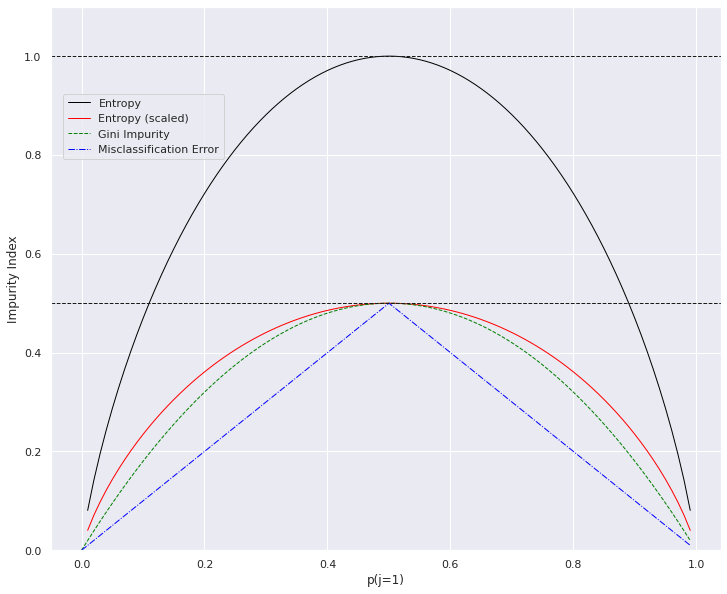

In [6]:
#@title Different criteria for binary classification
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def classification_error(p):
   return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
scaled_ent = [e*0.5 if e else None for e in ent]
c_err = [classification_error(i) for i in x]

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111)

for j, lab, ls, c, in zip(
      [ent, scaled_ent, gini(x), c_err],
      ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
      ['-', '-', '--', '-.'],
      ['black', 'red', 'green', 'blue']):
   line = ax.plot(x, j, label=lab, linestyle=ls, lw=1, color=c)

ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.85),
         ncol=1, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(j=1)')
plt.ylabel('Impurity Index')
plt.show()

**Example**

<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_11_decision_trees_and_random_forest/small_trees.png" width="600px" />

First, IG with Classification Error ($IG_E$):

$$
\begin{aligned}
 \text{Classification Error} &= 1-\max p_j \\
I_E(D_p) &= 1 - \frac{40}{80} = 1 - 0.5 = 0.5 \\
A:I_E(D_{left}) &= 1 - \frac{30}{40} = 1 - \frac34 = 0.25 \\
A:I_E(D_{right}) &= 1 - \frac{30}{40} = 1 - \frac34 = 0.25 \\
IG(D_p) &= I(D_p) - \frac{N_{left}}{N_p}I(D_{left}) - \frac{N_{right}}{N_p}I(D_{right}) \\
 A:IG_E &= 0.5 - \frac{40}{80} \times 0.25 - \frac{40}{80} \times 0.25 = 0.5 - 0.125 - 0.125 = \color{blue}{0.25} \\
B:I_E(D_{left}) &= 1 - \frac{40}{60} = 1 - \frac23 = \frac13 \\
B:I_E(D_{right}) &= 1 - \frac{20}{20} = 1 - 1 = 0 \\
B:IG_E &= 0.5 - \frac{60}{80} \times \frac13 - \frac{20}{80} \times 0 = 0.5 - 0.25 - 0 = \color{blue}{0.25} \\
\end{aligned}
$$

<br>
<p>The information gains using the classification error as a splitting
criterion are the same (0.25) in both cases A and B.</p>
<br>
<p><b>IG</b> with <b>Gini index ($IG_G$)</b>:</p>

$$ 
\begin{aligned}
\text{Gini} &= 1-\sum_jp_j^2 \\
I_G(D_p) &= 1 - \left( \left(\frac{40}{80} \right)^2 + \left(\frac{40}{80}\right)^2 \right) = 1 - (0.5^2+0.5^2) =  0.5 \\
A:I_G(D_{left}) &= 1 - \left( \left(\frac{30}{40} \right)^2 + \left(\frac{10}{40}\right)^2 \right) =  1 - \left( \frac{9}{16} + \frac{1}{16} \right) = \frac38 =  0.375 \\
 A:I_G(D_{right}) &= 1 - \left( \left(\frac{10}{40}\right)^2 + \left(\frac{30}{40}\right)^2 \right) =  1 - \left(\frac{1}{16}+\frac{9}{16}\right) = \frac38 =  0.375 \\
 A:I_G &= 0.5 - \frac{40}{80} \times 0.375 - \frac{40}{80} \times 0.375 = \color{blue}{0.125} \\
 B:I_G(D_{left}) &= 1 - \left( \left(\frac{20}{60} \right)^2 + \left(\frac{40}{60}\right)^2 \right) =  1 - \left( \frac{9}{16} + \frac{1}{16} \right) = 1 - \frac59 =  0.44 \\
 B:I_G(D_{right}) &= 1 - \left( \left(\frac{20}{20}\right)^2 + \left(\frac{0}{20}\right)^2 \right) =  1 - (1+0) = 1 - 1 =  0 \\
 B:I_G &= 0.5 - \frac{60}{80} \times 0.44 - 0 = 0.5 - 0.33 = \color{blue}{0.17} 
\end{aligned}
$$

<p>So, the <b>Gini index</b> favors the split <b>B</b>.</p>
<br>
<p><b>IG</b> with <b>Entropy ($IG_H$)</b>:</p>

$$
\begin{aligned}
\text{Entropy} &= -\sum_jp_j\log_2p_j \\
I_H(D_p) &= - \left( 0.5\log_2(0.5) + 0.5\log_2(0.5) \right) = 1 \\
A:I_H(D_{left}) &= - \left( \frac{30}{40}\log_2 \left(\frac{30}{40} \right) + \frac{10}{40}\log_2 \left(\frac{10}{40} \right) \right) = 0.81 \\
A:I_H(D_{right}) &= - \left( \frac{10}{40}\log_2 \left(\frac{10}{40} \right) + \frac{30}{40}\log_2 \left(\frac{30}{40} \right) \right) = 0.81 \\
A:IG_H &= 1 - \frac{40}{80} \times 0.81 - \frac{40}{80} \times 0.81 = \color{blue}{0.19} \\
B:I_H(D_{left}) &= - \left( \frac{20}{60}\log_2 \left(\frac{20}{60} \right) + \frac{40}{60}\log_2 \left(\frac{40}{60} \right) \right) = 0.92 \\
B:I_H(D_{right}) &= - \left( \frac{20}{20}\log_2 \left(\frac{20}{20} \right) + 0 \right) = 0 \\
B:IG_H &= 1 - \frac{60}{80} \times 0.92 - \frac{20}{80} \times 0 = \color{blue}{0.31} 
 \end{aligned}
 $$
<p>So, the entropy criterion favors <b>B</b>.</p>

#Motivating Random Forests: Decision Trees

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a4/Piet_Mondriaan%2C_1930_-_Mondrian_Composition_II_in_Red%2C_Blue%2C_and_Yellow.jpg/591px-Piet_Mondriaan%2C_1930_-_Mondrian_Composition_II_in_Red%2C_Blue%2C_and_Yellow.jpg" width="500px" />

**Piet Mondriaan**, Composition with Red, Blue, and Yellow, *oil and paper on canvas* (1930)




##Creating a decision tree

**The Basic Algorithm**
* `Start at the root node as parent node`
* `Split the parent node at the feature` $f_i(x)$ `to minimize the sum of the child node impurities (maximize information gain)`
* `Assign training samples to new child nodes`
* `Stop if leave nodes are pure or early stopping criteria is satisfied, else repeat steps 1 and 2 for each new child node`

**Stopping Rules**
* `The leaf nodes are pure`
* `A maximal node depth is reached`
* `Splitting a note does not lead to an information gain`

**Classification Error vs. Entropy**

Consider the following tree (perfect splitting)

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_11_decision_trees_and_random_forest/tree_original.png)

Now, is it possible to learn this hypothesis (i.e., tree model) by minimizing the classification error as a criterion function?

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_11_decision_trees_and_random_forest/tree_error.png)

The Information Gain after the first split is exactly 0, since average classification error of the 2 child nodes is exactly the same as the classification error of the parent node.
**Training stops at the first split.**


![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_11_decision_trees_and_random_forest/tree_entropy.png)

The average child node entropy is not equal to the entropy of the parent node. Thus, the splitting rule would continue until the child nodes are pure (after the next 2 splits).

![](https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_11_decision_trees_and_random_forest/classification_error_is_bad_explanation.png)

To recapitulate: the decision tree algorithm aims to find the feature and splitting value that leads to a maximum decrease of the average child node impurities over the parent node. So, if we have 2 entropy values (left and right child node), the average will fall onto the straight, connecting line. However – and this is the important part – we can see that the Entropy is always larger than the averaged Entropy due to its “bell shape,” which is why we keep continuing to split the nodes in contrast to the classification error.

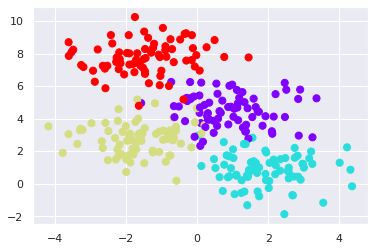

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
  ax = ax or plt.gca()
  
  # Plot the training points
  ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
  ax.axis('tight')
  ax.axis('off')
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  
  xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  
  # Create a color plot with the results
  n_classes = len(np.unique(y))
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=cmap, zorder=1)
  ax.set(xlim=xlim, ylim=ylim)

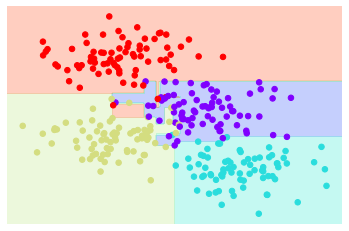

In [ ]:
visualize_classifier(tree, X, y)

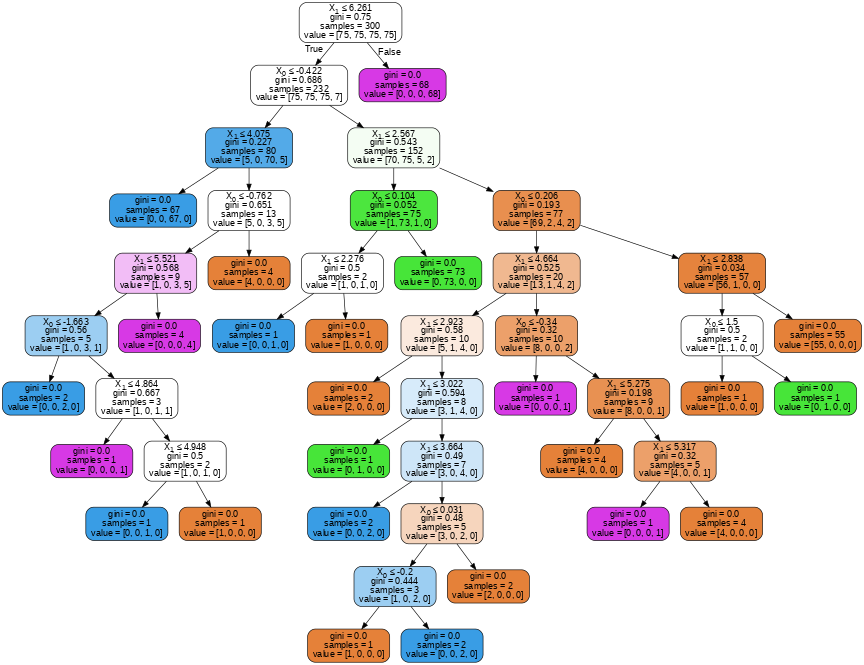

In [ ]:
from sklearn import tree as Tree
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = Tree.export_graphviz(tree,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.set_size('"9,9!"')
Image(graph.create_png())

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True, xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis', clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap='viridis', zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i], [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i], [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim, [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim, [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 2, 3, 4, 5])
    
plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=4, options=(1, 2, 3, 4, 5), value=5), Output()), _do…

##Decision trees and overfitting

Such overfitting turns out to be a general property of decision trees; it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties.

In [3]:
def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False, xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 5, 10, 20, 50, 75, 100]);
    
randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 5, 10, 20, 50, 75, 100), value=0), Outp…

#Ensembles of Estimators: Random Forests

Any composition on decision trees is decision forest.

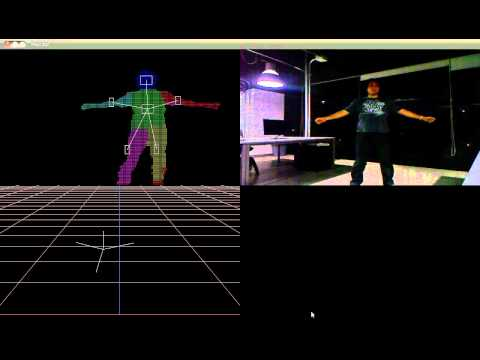

In [ ]:
#@title Microsoft Kinect (Random Forests) { display-mode: "form" }
from IPython.display import YouTubeVideo
YouTubeVideo('gwovIigpkTo', width=600, height=400)

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called **bagging** = bootstrapping + aggregating (bootstrap datasets are generated with IID). Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data, and averages the results to find a better classification. An ensemble of randomized decision trees is known as a **random forest**.

Trees are well-busted due to their instability. 
Hard to boost SVM (too stable).

<img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_11_decision_trees_and_random_forest/bagging_trees.png" width="600px" />


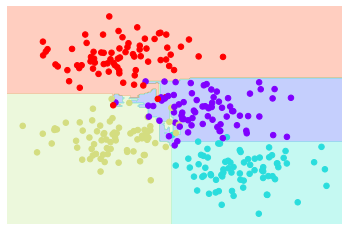

In [ ]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
  ax = ax or plt.gca()
  
  # Plot the training points
  ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
  ax.axis('tight')
  ax.axis('off')
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  
  # fit the estimator
  model.fit(X, y)
  xx, yy = np.meshgrid(np.linspace(*xlim, num=200), np.linspace(*ylim, num=200))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  
  # Create a color plot with the results
  n_classes = len(np.unique(y))
  contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=cmap, zorder=1)
  ax.set(xlim=xlim, ylim=ylim)
  

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)
bag.fit(X, y)

visualize_classifier(bag, X, y)

**Meta-algorithm that builds forest**

* Form a large set of simple features
* Initialize weights for training set
* For T rounds
    - Normalize the weights
    - For available features from the set, train a classifier using a single feature and evaluate the training error
    - Choose the classifier with the lowest error
    - Update the weights of the training images: increase if classified wrongly by this classifier, decrease if correctly
* Form the final strong classifier as the linear combination of the T classifiers (coefficient larger if training error is small)

* Trees vote
* Every tree is trained on random sample with return  (covers $\approx 63\%$)
* Not all features are used ($1/3$ only)
* Gini criterion
* No pruning

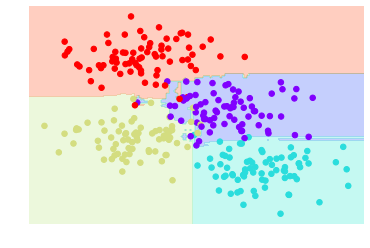

In [ ]:
# RandomForestClassifier takes care of all the desired randomness
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);
#averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition

* AdaBoost = Random forest of stumps.

#Random Forest Regression

* Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables).
* Instead of taking some class with most votes we average the result to get regression.

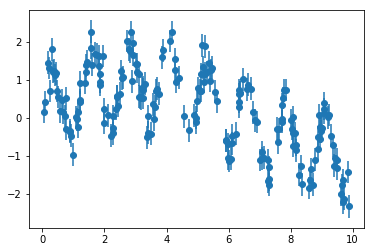

In [ ]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
  fast_oscillation = np.sin(5 * x)
  slow_oscillation = np.sin(0.5 * x)
  noise = sigma * rng.randn(len(x))
  return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

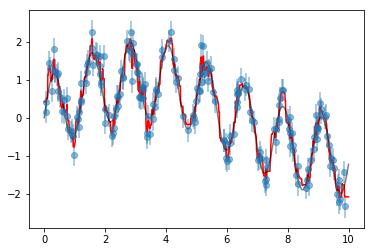

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

# random forest model is flexible enough to fit the multiperiod data, 
# without us needing to specify a multiperiod model!

#Example: Random Forest for Classifying Digits

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

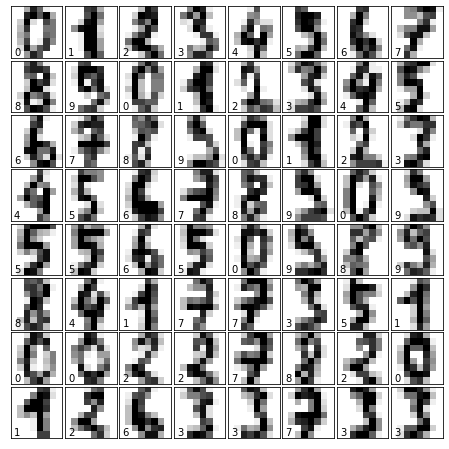

In [ ]:
import matplotlib.pyplot as plt

# set up the figure
fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
  ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
  ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
  
  # label the image with the target value
  ax.text(0, 7, str(digits.target[i]))

[ 0.  1.  9. 16. 13.  7.  0.  0.  0.  7. 14.  4. 10. 12.  0.  0.  0.  6.
 15.  9. 16. 11.  0.  0.  0.  0.  9. 11.  7. 14.  0.  0.  0.  0.  0.  0.
  0. 15.  2.  0.  0.  0.  0.  0.  0. 11.  6.  0.  0.  3. 13.  8.  5. 14.
  5.  0.  0.  0.  9. 14. 13. 10.  1.  0.]
[[ 0.  1.  9. 16. 13.  7.  0.  0.]
 [ 0.  7. 14.  4. 10. 12.  0.  0.]
 [ 0.  6. 15.  9. 16. 11.  0.  0.]
 [ 0.  0.  9. 11.  7. 14.  0.  0.]
 [ 0.  0.  0.  0.  0. 15.  2.  0.]
 [ 0.  0.  0.  0.  0. 11.  6.  0.]
 [ 0.  3. 13.  8.  5. 14.  5.  0.]
 [ 0.  0.  9. 14. 13. 10.  1.  0.]]


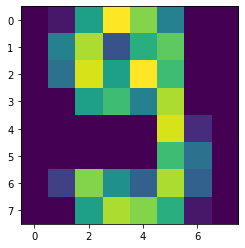

In [ ]:
print(digits.data[39])
print(digits.images[39])
plt.imshow(digits.images[39])

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target, random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.98      0.98        43
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.96      0.98      0.97        47
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



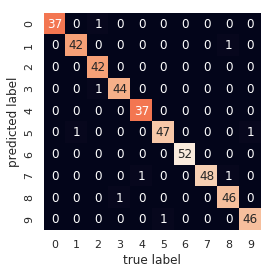

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#Summary of Random Forests

*   Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
*   The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in `Scikit-Learn` with the `predict_proba()` method).
*   The nonparametric model is extremely flexible, and can thus perform well on
tasks that are underfit by other estimators.
* Less overfit

**Disadvantage**

Results are not easily interpretable